# Imports

In [15]:
import os, sys, json
import numpy as np
# Determine project root (parent of notebooks directory)
current_dir = os.path.abspath(os.getcwd())
# If running from project root, notebooks/ may not be in path; handle both cases
if os.path.basename(current_dir).lower() == "notebooks":
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
else:
    # Assume we launched from project root already
    project_root = current_dir

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

try:
    from networks import SpikingNetwork
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import SpikingNetwork from {src_path}: {e}")
try:
    from connections import *
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import connections from {src_path}: {e}")
try: 
    from utils import *
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import utils from {src_path}: {e}")
try:
    from inputs import *
except ModuleNotFoundError as e:
    raise RuntimeError(f"Failed to import inputs from {src_path}: {e}")

# Load config file robustly
config_path = os.path.join(project_root, "configs", "baseline_izhikevich.json")
#config_path = os.path.join(project_root, "configs", "baseline_lif.json")
with open(config_path, "r") as f:
    config = json.load(f)
print("Loaded config from", config_path)
import torch

Loaded config from c:\Users\Work\VSCodeProjects\spiking-network-info-transmission\configs\baseline_izhikevich.json


# Create weight matrices & network

No learning for lateral connections.
No learning for feedforward connections.


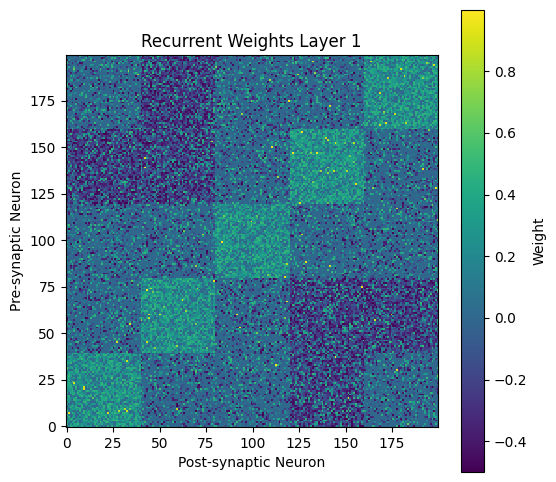

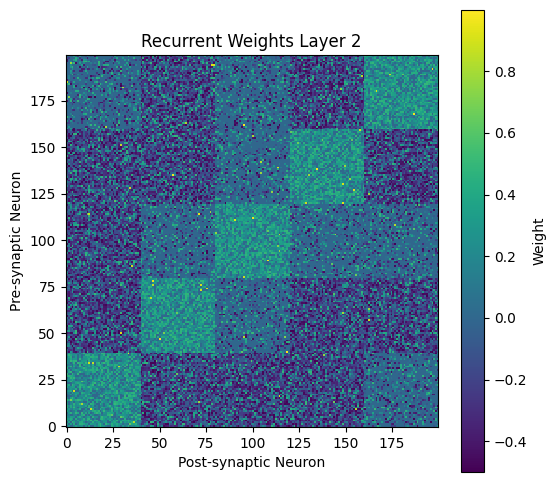

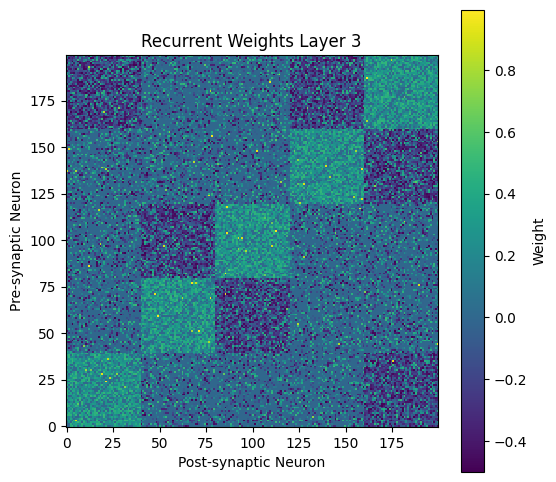

In [16]:
net = SpikingNetwork(config)
ff1 = connect_one_to_one(config["n_inputs"], config["n_layer_one"])
ff2 = connect_one_to_one(config["n_layer_one"], config["n_layer_two"])
ff3 = connect_one_to_one(config["n_layer_two"], config["n_layer_three"])
if config["cluster_size"] > 0:
    rec1 = connect_clustered_lateral(config["n_layer_one"], n_clusters=config["cluster_size"], p_intra=0.8, connect_clusters=True, exclude_self=True) * config["weight_strength"] + connect_random(config["n_layer_one"], config["n_layer_one"], p=config["noise_level"]) * config["weight_strength"]
    rec2 = connect_clustered_lateral(config["n_layer_one"], n_clusters=config["cluster_size"], p_intra=0.8, connect_clusters=True, exclude_self=True) * config["weight_strength"] + connect_random(config["n_layer_two"], config["n_layer_two"], p=config["noise_level"]) * config["weight_strength"]
    rec3 = connect_clustered_lateral(config["n_layer_one"], n_clusters=config["cluster_size"], p_intra=0.8, connect_clusters=True, exclude_self=True) * config["weight_strength"] + connect_random(config["n_layer_three"], config["n_layer_three"], p=config["noise_level"]) * config["weight_strength"]
else:
    rec1 = connect_random(config["n_layer_one"], config["n_layer_one"], p=config["noise_level"]) * config["weight_strength"]
    rec2 = connect_random(config["n_layer_two"], config["n_layer_two"], p=config["noise_level"]) * config["weight_strength"]
    rec3 = connect_random(config["n_layer_three"], config["n_layer_three"], p=config["noise_level"]) * config["weight_strength"]
net.add_weights(ff1, rec1, ff2, rec2, ff3, rec3)
net.build()
visualize_weight_matrix(rec1, title="Recurrent Weights Layer 1")
visualize_weight_matrix(rec2, title="Recurrent Weights Layer 2")
visualize_weight_matrix(rec3, title="Recurrent Weights Layer 3")

torch.Size([500, 200]) torch.Size([500, 200]) torch.Size([500, 200]) torch.Size([500, 200])


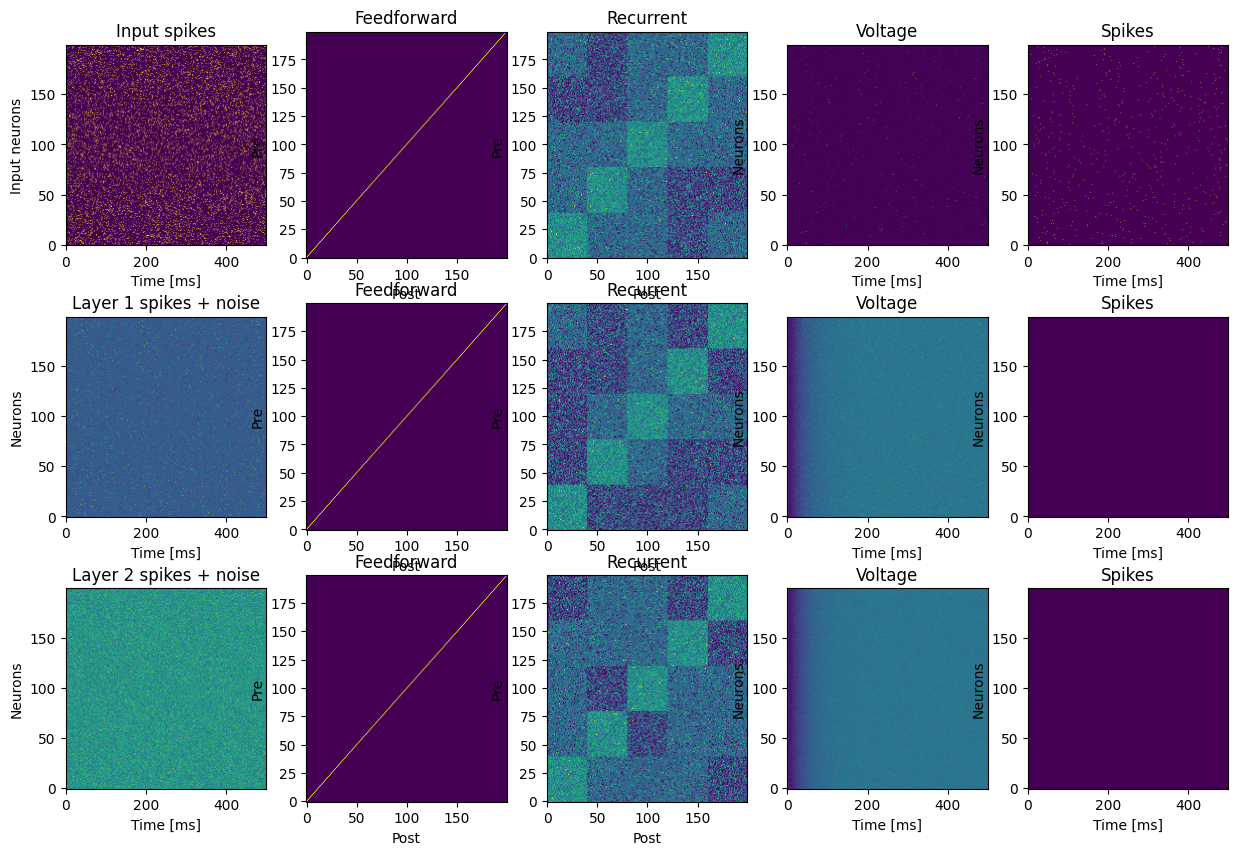

In [17]:
input_data = torch.bernoulli(0.1 * torch.ones(config["time"], config["n_inputs"])).byte() * 10
# initial input to one to one
# try target clusterwise and check activity
net.run(input_data, input_mean=config["noise_mean"], input_scale=config["noise_scale"])
# add check if connection weight have increased
net.plot_last(config)

torch.Size([500, 200])
torch.Size([500, 200]) torch.Size([500, 200]) torch.Size([500, 200]) torch.Size([500, 200])


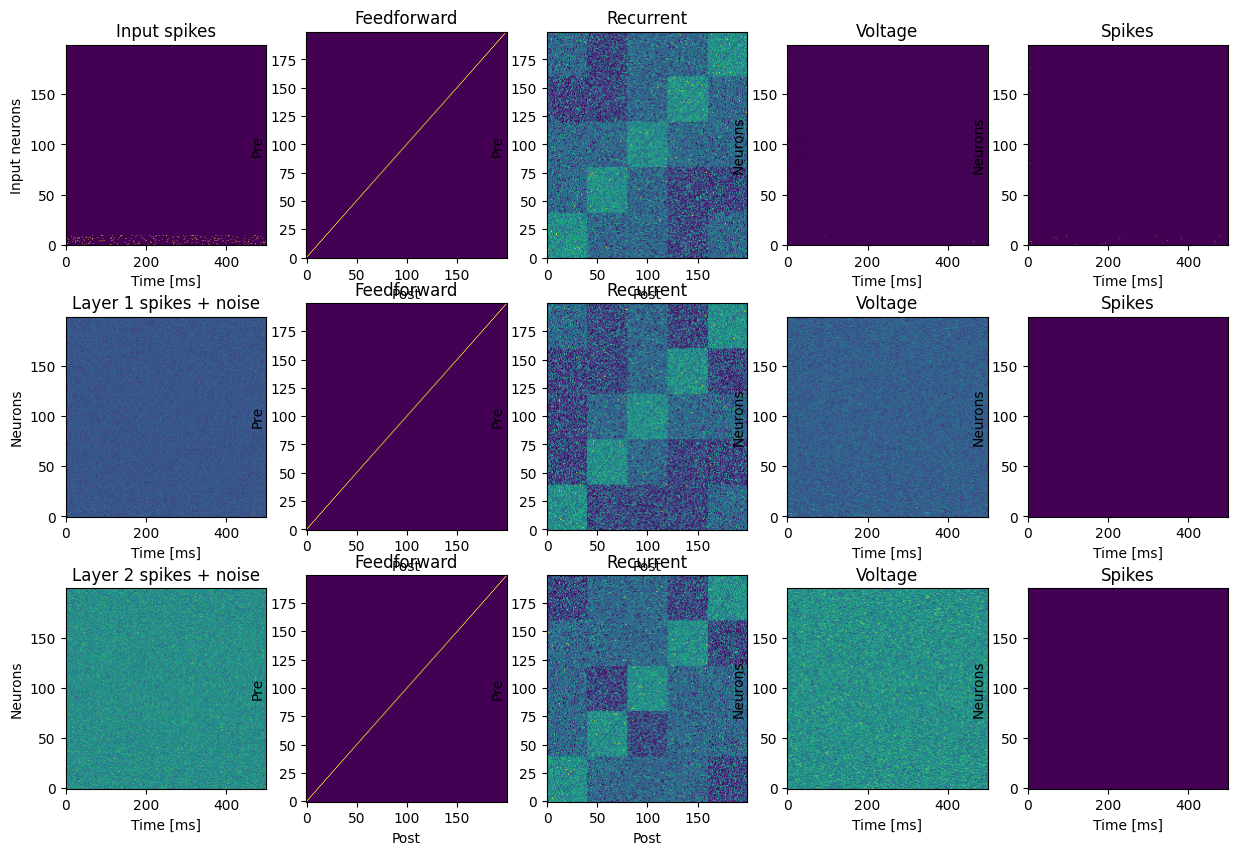

In [18]:
# Params
n_inputs   = 100
n_neurons  = 100
dt         = 1.0
sim_length = 500
T          = net.time

# Stimulate a group of neurons
target_idx  = np.arange(10)
target_rate = 50.0
bg_rate     = 0.0

poisson_spikes = poisson_input(
    T, n_inputs, dt,
    target_idx,
    target_rate,
    bg_rate,
    batch_size=1
)
I_ext = torch.from_numpy(poisson_input(T, config["n_inputs"], dt, target_idx, target_rate, bg_rate)) * 10

I_ext = I_ext.squeeze(1)
print(I_ext.shape)
net.run(I_ext, input_mean=config["noise_mean"], input_scale=config["noise_scale"])
# add check if connection weight have increased
# sparsity
# look for synchrony function
net.plot_last(config)

(array([[0., 0., 5., ..., 3., 0., 0.],
        [0., 0., 7., ..., 6., 1., 0.],
        [0., 0., 7., ..., 2., 1., 0.],
        ...,
        [0., 0., 5., ..., 1., 0., 0.],
        [0., 1., 5., ..., 2., 2., 0.],
        [0., 1., 5., ..., 4., 0., 0.]], shape=(400, 10)),
 array([-0.48116099, -0.38393248, -0.28670396, -0.18947544, -0.09224692,
         0.0049816 ,  0.10221011,  0.19943863,  0.29666715,  0.39389567,
         0.49112419]),
 <a list of 400 BarContainer objects>)

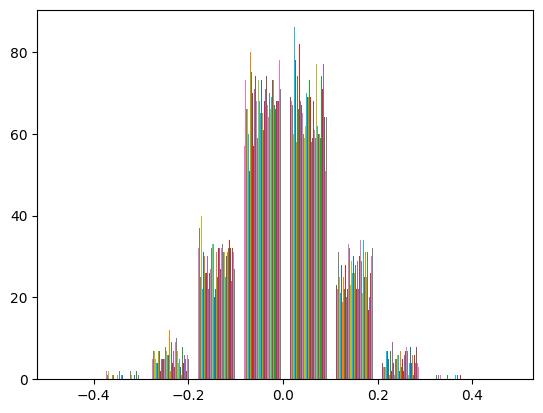

In [19]:
plt.hist(np.random.normal(loc=config["noise_mean"], scale=config["noise_scale"], size=(200, 400)))
